In [9]:
import numpy as np
from scipy.sparse import csgraph
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.ndimage import laplace
from numpy.random import randint, rand
from tqdm import tqdm

In [41]:
def spatial_PDE(N,b,k,p,T,I0,M=200):
    """
    A spatial PDE simulation that model time dependent variables: S, I, R
    
    N: N individuals the population has
    
    b: the number of interactions each day that could spread the disease (per individual)
    
    k: the fraction of the infectious population which recovers each day
    
    T: simulation time period
    
    I0: Initial positions of infectious individuals
    
    M: size of grid
    
    """
    def laplace_flat(A):
        A = A.reshape((M,M))
        return laplace(A).flatten()
        
    def f(t,v):
        """
        v = [S, I, R]
        
        """
        # print(v.shape)
        S = v[:M**2]
        I = v[M**2:-M**2]
        R = v[-M**2:]
        
        # derivatives
        dSdt = -b * S * I + p * laplace_flat(S)
        dIdt = b * S * I - k * I + p * laplace_flat(I)
        dRdt = k * I + p * laplace_flat(R)
        
        return np.concatenate([dSdt, dIdt, dRdt],axis=None)
    
    
    # get intial S0 and R0 from I0
    S0 = np.ones((M*M))-I0
    R0 = np.zeros((M*M))
    
    # solve_ivp only accept 1d initial value, so conbine 3 1d array to 1
    v0 = np.concatenate([S0,I0,R0],axis=None)
    
    t_span = [0,T]
    t_eval = list(range(T))
    sol = solve_ivp(f, t_span, v0, t_eval=t_eval)
    return sol

100%|██████████| 6/6 [04:02<00:00, 40.37s/it]


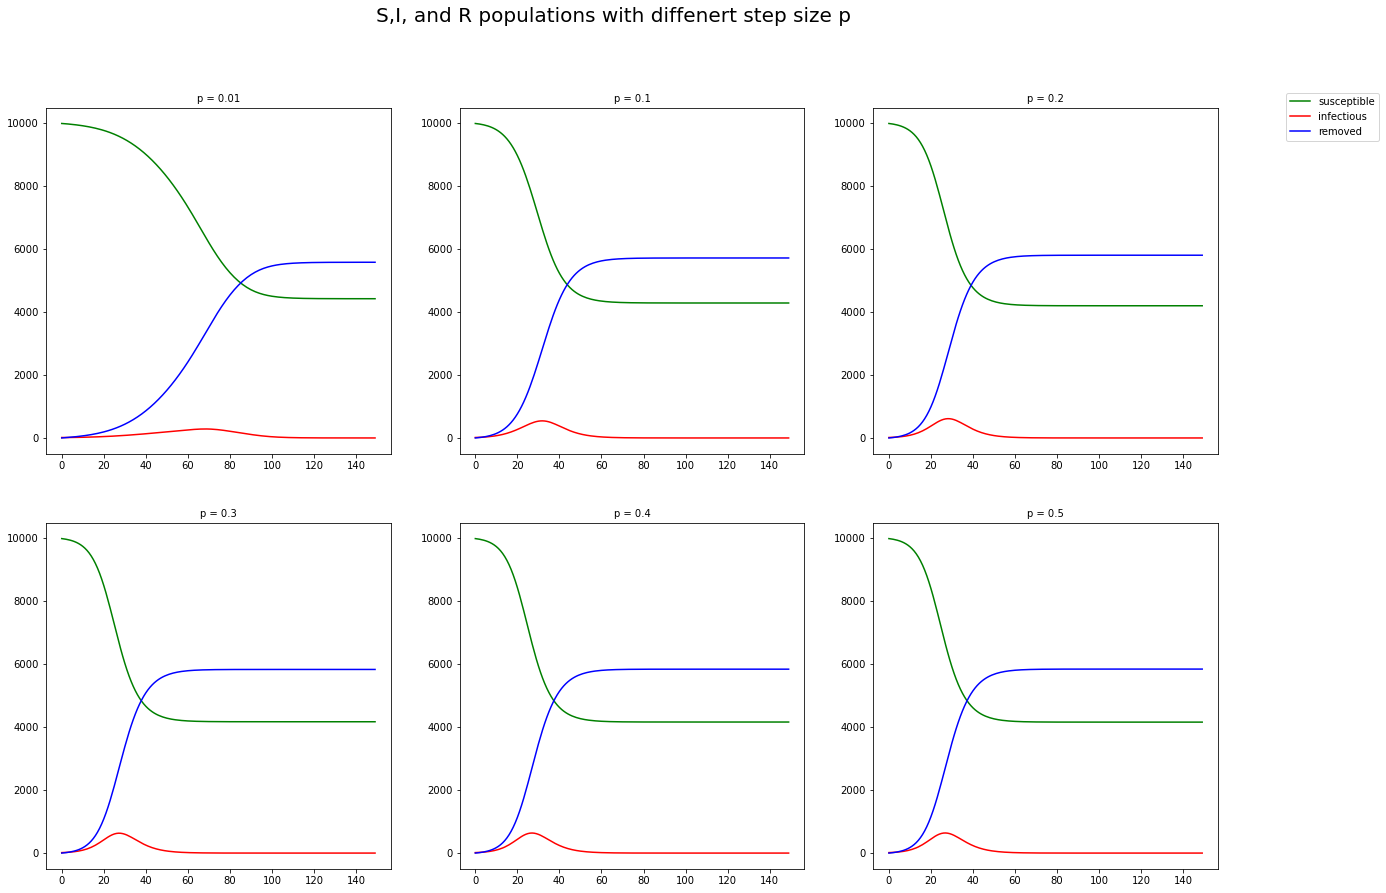

In [54]:
### infected individuals start at the center of the square

k = 0.4
b = 0.6

M = 100
T = 150
N = M**2
# grids with 1s and 0s, 1s are the infected
# i0 = M # number of the infected
# I0 = np.random.choice([1]*i0+[0]*(M*M-i0), size=(M**2), replace=False)
I0 = np.zeros((M,M))
midpart = (np.random.rand(5,5)>0.5)*1
I0[48:53,48:53] = midpart[:,:]
I0 = I0.flatten()
       
p_list = [1,10,20,30,40,50]
fig, ax = plt.subplots(2,3, figsize=(21,14))

fig.suptitle("S,I, and R populations with diffenert step size p",fontsize=20)

I_max = []
I_max_t = []
total_infect = []

for ind in tqdm(range(len(p_list))):
      
    i = ind//3
    j = ind%3
    p = p_list[ind]
    sol = spatial_PDE(N,b,k,p,T,I0,M=M)

    S = []
    I = []
    R = []
    for dayind in range(T):
        S.append(np.sum(sol.y[:,dayind][:M**2]))
        I.append(np.sum(sol.y[:,dayind][M**2:-M**2]))
        R.append(np.sum(sol.y[:,dayind][-M**2:]))
    
    Imax = np.max(I)
    I_max.append(Imax)
    I_max_t.append(I.index(Imax))
    total_infect.append(I[-1]+R[-1])
    
    ax[i,j].plot(list(range(T)), S, label="susceptible", c='g')
    ax[i,j].plot(list(range(T)), I, label="infectious", c='r')
    ax[i,j].plot(list(range(T)), R, label="removed", c='b')

    ax[i,j].set_title(f"p = {p/100}",fontsize=10)
        
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(1.01, 0.9),loc = 'upper right')

In [50]:
for p in range(6):
    if p==0:
        print('p =', 0.01)
    else:
        print('p =', p*10)
    print('maxima of I:', I_max[p])
    print('time that maxima appears:', I_max_t[p])
    print('total number of infected individual(I+R):', total_infect[p])
    print()

p = 0.01
maxima of I: 285.7161545011482
time that maxima appears: 69
total number of infected individual(I+R): 5581.314728125126

p = 10
maxima of I: 552.4302804957744
time that maxima appears: 33
total number of infected individual(I+R): 5728.333906370186

p = 20
maxima of I: 616.7655704613255
time that maxima appears: 30
total number of infected individual(I+R): 5808.244173071325

p = 30
maxima of I: 631.2667502368965
time that maxima appears: 29
total number of infected individual(I+R): 5830.177815523612

p = 40
maxima of I: 634.8622663799125
time that maxima appears: 29
total number of infected individual(I+R): 5836.058240054987

p = 50
maxima of I: 635.686061206766
time that maxima appears: 29
total number of infected individual(I+R): 5837.8217142008725



From the plots and data above, one can see that, As step size p increases, the maximum value of I (population of the infected) will also increase, and the time when the maximum value of I appears will be earlier. While the rate of rise and fall will gradually decrease. This means that as the distance of travel increases, infected individuals are more likely to infect other people and the spreading goes faster.

In addition, as p increases, the total number of final infections (I + R) also increases slightly. The growing trend is not quite obvious under this case, which may be related to the choice of parameters.

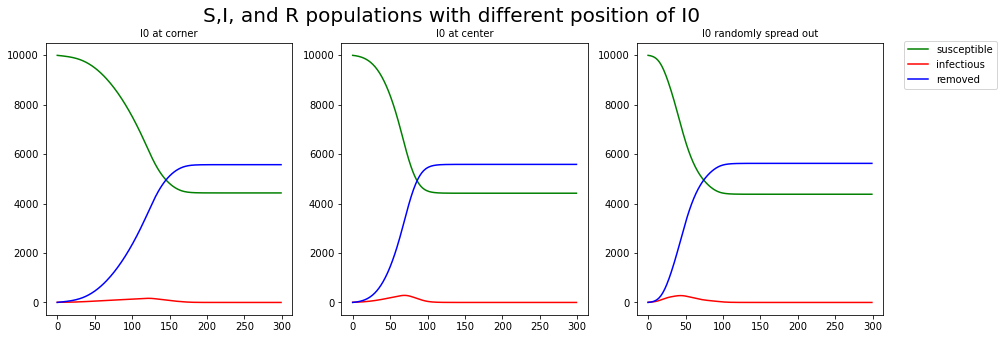

In [55]:
### compare between different I0

### infected individuals start at the center of the square

k = 0.4
b = 0.6
M = 100
N = M**2
T = 300
p = 1

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("S,I, and R populations with different position of I0",fontsize=20)

# grids with 1s and 0s, 1s are the infected

midpart = (np.random.rand(5,5)>0.5)*1
i0 = np.sum(midpart) # number of the infected

I_max = []
I_max_t = []
total_infect = []

## 0
I0 = np.zeros((M,M))
I0[0:5,0:5] = midpart[:,:]
I0 = I0.flatten()       
        
sol = spatial_PDE(N,b,k,p,T,I0,M)

S = []
I = []
R = []
for dayind in range(T):
    S.append(np.sum(sol.y[:,dayind][:M**2]))
    I.append(np.sum(sol.y[:,dayind][M**2:-M**2]))
    R.append(np.sum(sol.y[:,dayind][-M**2:]))

Imax = np.max(I)
I_max.append(Imax)
I_max_t.append(I.index(Imax))
total_infect.append(I[-1]+R[-1])

ax[0].plot(list(range(T)), S, label="susceptible", c='g')
ax[0].plot(list(range(T)), I, label="infectious", c='r')
ax[0].plot(list(range(T)), R, label="removed", c='b')
ax[0].set_title(f"I0 at corner",fontsize=10)

## 1
I0 = np.zeros((M,M))
I0[48:53,48:53] = midpart[:,:]
I0 = I0.flatten()       
        
sol = spatial_PDE(N,b,k,p,T,I0,M)

S = []
I = []
R = []
for dayind in range(T):
    S.append(np.sum(sol.y[:,dayind][:M**2]))
    I.append(np.sum(sol.y[:,dayind][M**2:-M**2]))
    R.append(np.sum(sol.y[:,dayind][-M**2:]))

Imax = np.max(I)
I_max.append(Imax)
I_max_t.append(I.index(Imax))  
total_infect.append(I[-1]+R[-1])
    
ax[1].plot(list(range(T)), S, label="susceptible", c='g')
ax[1].plot(list(range(T)), I, label="infectious", c='r')
ax[1].plot(list(range(T)), R, label="removed", c='b')
ax[1].set_title(f"I0 at center",fontsize=10)

## 2
I0 = np.random.choice([1]*i0+[0]*(M*M-i0), size=(M**2), replace=False)      
        
sol = spatial_PDE(N,b,k,p,T,I0,M)

S = []
I = []
R = []
for dayind in range(T):
    S.append(np.sum(sol.y[:,dayind][:M**2]))
    I.append(np.sum(sol.y[:,dayind][M**2:-M**2]))
    R.append(np.sum(sol.y[:,dayind][-M**2:]))

Imax = np.max(I)
I_max.append(Imax)
I_max_t.append(I.index(Imax))
total_infect.append(I[-1]+R[-1])
    
ax[2].plot(list(range(T)), S, label="susceptible", c='g')
ax[2].plot(list(range(T)), I, label="infectious", c='r')
ax[2].plot(list(range(T)), R, label="removed", c='b')
ax[2].set_title(f"I0 randomly spread out",fontsize=10)

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(1.01, 0.9),loc = 'upper right')


In [56]:
title = ['I0 at corner', 'I0 at center', 'I0 redomly spread out']
for i in range(3):
    print(title[i])
    print('maxima of I:', I_max[i])
    print('time that maxima appears:', I_max_t[i])
    print('total number of infected individual(I+R):', total_infect[i])
    print()

I0 at corner
maxima of I: 166.55842927249512
time that maxima appears: 122
total number of infected individual(I+R): 5571.317027724037

I0 at center
maxima of I: 285.6855555684634
time that maxima appears: 69
total number of infected individual(I+R): 5582.937062763236

I0 redomly spread out
maxima of I: 276.979390697677
time that maxima appears: 43
total number of infected individual(I+R): 5624.198683696779



The plots and data above show how the starting position of the initial infected individual affects the dynamics of the system. Among the three cases, when I0 (the initial infected individuals) is randomly spread out in the area, the number of the infected (I) reaches its top the earlist and the maxima number is the largest. Also the total number of final infections (I + R) is also the largest among three cases. On contrary, when starting in a single corner of the square, the maxima of I and the final number of (I + R) is the smallest and the time that maxima appears is the latest.

This shows that scattered infected people are more potentially dangerous than clustered infected people, because scattered allows them to reach more uninfected people, which as a result makes more people infected.

As the conclusion of the spatial part, some suggestions can be made about slowing or preventing the spread of the disease.
    1. Promote quarantine to limit people's range of activities
    2. Gather the infected or confirmed populations and isolate them within the planned scope

In [127]:
# k = 1
# b = 1

# M = 200
# N = 40000
# T = 100
# # grids with 1s and 0s, 1s are the infected
# i0 = 100 # number of the infected
# I0 = np.random.choice([1]*i0+[0]*(M*M-i0), size=(M**2), replace=False)
# # I0 = np.array([1]*M+[0]*(M*M-M))

# p = 1
        
# sol = spatial_PDE(N,b,k,p,T,I0,M)

# # print(sol.y.shape)
# # y has shape (M*M*3,T)
# # ith column is the 1d array contains the info of the ith day

# S = []
# I = []
# R = []
# for dayind in range(T):
#     S.append(sol.y[:,dayind][:M**2].reshape((M,M)))
#     I.append(sol.y[:,dayind][M**2:-M**2].reshape((M,M)))
#     R.append(sol.y[:,dayind][-M**2:].reshape((M,M)))
# S = np.array(S)
# I = np.array(I)
# R = np.array(R)

# # print(S)
# # print(I)
# # print(R)

# Sy = np.array(range(T))
# Iy = np.array(range(T))
# Ry = np.array(range(T))
# for i in range(T):
#     Sy[i] = np.sum(S[i])
#     Iy[i] = np.sum(I[i])
#     Ry[i] = np.sum(R[i])
    

In [148]:
# plt.plot(list(range(T)), Sy, label="susceptible", c='g')
# plt.plot(list(range(T)), Iy, label="infectious", c='r')
# plt.plot(list(range(T)), Ry, label="removed", c='b')
# plt.legend()


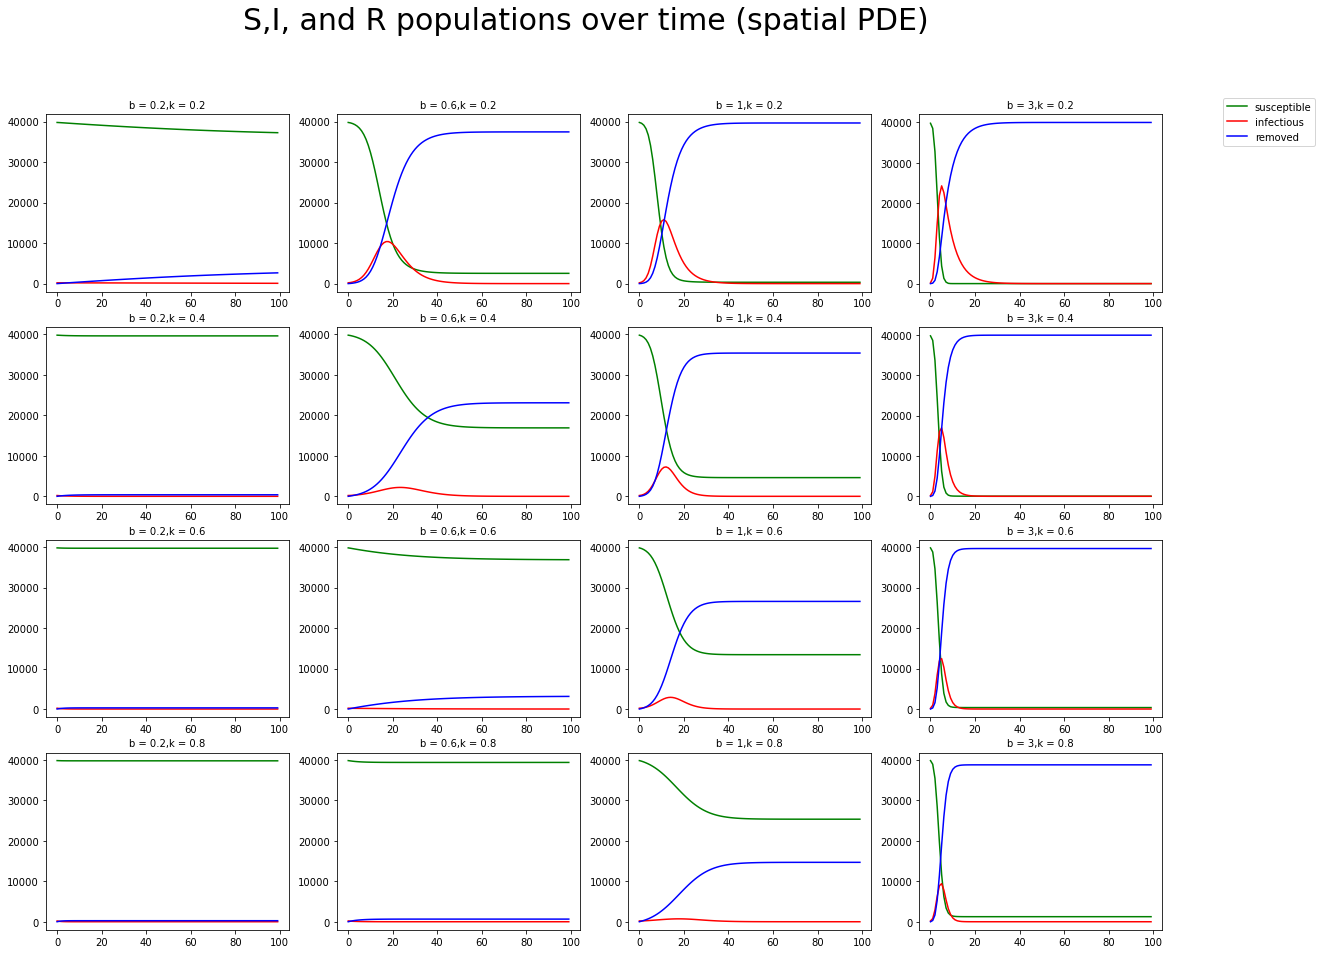

In [147]:
# useless trash
### script to plot s i r over time with different k and b

k_list = [1/5,2/5,3/5,4/5]
b_list = [1/5,3/5,1,3]

fig, ax = plt.subplots(len(k_list),len(b_list), figsize=(15,15))

M = 200
T = 100
# grids with 1s and 0s, 1s are the infected
i0 = M # number of the infected
I0 = np.random.choice([1]*i0+[0]*(M*M-i0), size=(M**2), replace=False)
p = 1

fig.suptitle("S,I, and R populations over time (spatial PDE)",fontsize=30)
for i,k in enumerate(k_list):
    for j,b in enumerate(b_list):
        
        sol = spatial_PDE(N,b,k,p,T,I0,M)
        
        S = []
        I = []
        R = []
        for dayind in range(T):
            S.append(np.sum(sol.y[:,dayind][:M**2]))
            I.append(np.sum(sol.y[:,dayind][M**2:-M**2]))
            R.append(np.sum(sol.y[:,dayind][-M**2:]))
        
        ax[i,j].plot(list(range(T)), S, label="susceptible", c='g')
        ax[i,j].plot(list(range(T)), I, label="infectious", c='r')
        ax[i,j].plot(list(range(T)), R, label="removed", c='b')
        
        ax[i,j].set_title(f"b = {b},k = {k}",fontsize=10)
        
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, bbox_to_anchor=(1.01, 0.9),loc = 'upper right')